## Use states as voters instead of congressmen

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import re

import glob, os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from shapely.geometry import LineString

import shapely

In [2]:
mmb = pd.read_csv('../dataset/HSall_members.csv')
pc = pd.read_csv('../dataset/HSall_parties.csv')

In [3]:
def create_members_df():
    temp_congress = mmb.groupby('icpsr', as_index=False)[['congress']].agg(lambda x: list(x))
    temp_party = mmb.groupby('icpsr', as_index=False)[['party_code']].agg(lambda x: list(set(x)))
    temp_congress = temp_congress.merge(temp_party)
    temp_congress['bioname'] = temp_congress['icpsr'].map(mmb[['icpsr', 'bioname']].set_index('icpsr').to_dict()['bioname'])
    temp_congress['state_abbrev'] = temp_congress['icpsr'].map(mmb[['icpsr', 'state_abbrev']].set_index('icpsr').to_dict()['state_abbrev'])
    temp_congress['district_code'] = temp_congress['icpsr'].map(mmb[['icpsr', 'district_code']].set_index('icpsr').to_dict()['district_code'])
    party_codes_dic = pc[['party_name', 'party_code']].set_index('party_code').to_dict()['party_name']
    temp_congress['party_name'] = temp_congress['party_code'].apply(lambda x: [party_codes_dic[y] for y in x])
    return temp_congress

members = create_members_df()

_________________________________________________________________________________________________

In [4]:
n_congress = '100'

In [5]:
members2state_dic = members.set_index('icpsr')['state_abbrev'].to_dict()
members2district_dic = members.set_index('icpsr')['district_code'].to_dict()
members_party_dict = members.set_index('icpsr')['party_name'].to_dict()

In [6]:
# try for congress 110
congress_prova = pd.read_csv('../dataset/download_votes_merged/congress_'+n_congress+'.csv')

In [7]:
# add the column of state_abbrev translating the icpsr
congress_prova['state_abbrev'] = congress_prova['icpsr'].map(members2state_dic)
congress_prova['code_district'] = congress_prova['icpsr'].map(members2state_dic)

Create the member-based edgelist (if you didn't do it already)

In [9]:
def create_edgelist_from_congress(congress, members_party_dict):
	edgelist = pd.DataFrame()

	for voteid in tqdm(set(congress['id'])):                 # iterate over all votes id (ids are unique for each vote)

		temp = congress[congress['id'] == voteid]            # select the rows where the vote id is equal to the current vote id            

		yy = temp[temp['vote']=='Yea']['icpsr']              # select the icpsr of the members that voted "Yea"
		nn = temp[temp['vote']=='Nay']['icpsr']                         

		y = itertools.combinations(yy, 2)                    # all possible combinations of 2 members that voted "Yea"
		n = itertools.combinations(nn, 2)                
		o = itertools.product(yy, nn)                        # cartesian product of the 2 series

		y = pd.DataFrame(y, columns = ['source', 'target'])  # create a dataframe from the combinations of "Yea" voters
		y['weight'] = 1                                      # add a column with the weight of the edge
		y['count'] = 1                                         

		n = pd.DataFrame(n, columns = ['source', 'target'])     
		n['weight'] = 1                                         
		n['count'] = 1                                          

		o = pd.DataFrame(o, columns = ['source', 'target'])     
		o['weight'] = -1                                     # same but the link is negative                    
		o['count'] = 1                                          

		edgelist = pd.concat([edgelist, y, n, o])
		edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count                  

	edgelist = pd.concat([edgelist, pd.DataFrame({
		'source': edgelist['target'],                        # new columns based on old columns: 
		'target': edgelist['source'],                        #   'newcolumn': dataframe['oldcolumn']
		'weight': edgelist['weight'],
		'count': edgelist['count']})])

	edgelist = edgelist.loc[edgelist['source'] < edgelist['target']]                    # remove duplicates
	edgelist = edgelist.groupby(['source', 'target', 'weight']).sum().reset_index()     # group by source, target and weight and sum the count
	edgelist['party'] = edgelist.apply(lambda row: 'in' if members_party_dict[row['source']] == members_party_dict[row['target']] else 'out', axis=1)   # create a column with the party of the edge

	map_votes = edgelist.groupby(['source', 'target'])['count'].sum().to_dict()                                                                         # create a dictionary with the number of votes togheter for each pair of nodes                               

	edgelist['votes_togheter'] = edgelist[['source', 'target']].apply(lambda x: map_votes[(x['source'], x['target'])], axis=1)
	edgelist['perc'] = edgelist['count']/edgelist['votes_togheter']

	return edgelist

In [10]:
def compute_threshold_intersx(df, weight):	#df is the edgelist, weight is the weight of the edge

	def _midpoint(p1, p2):
		return {'x': (p1['x']+p2['x'])/2, 'y': (p1['y']+p2['y'])/2}

	def line_intersection(in_party, out_party, intersect_points):
		index_in = np.argmax(in_party[1])
		index_out = np.argmax(out_party[1])

        # points of the mean of the distributions 
		point_in={'x': in_party[0][index_in], 'y': in_party[1][index_in]}
		point_out={'x': out_party[0][index_out], 'y': out_party[1][index_out]}

        # medianpoint (mean of the means) of the two distributions
		midpoint = _midpoint(point_in, point_out)
        
        #find index of intersection closer to midpoint
		index_closer = np.argmin([np.sqrt( (p[0] - midpoint['x'])**2 + (p[1] - midpoint['y'])**2 ) for p in intersect_points])

        # return x value of closer intersection
		return intersect_points[index_closer][0]

	x0 = df.loc[(df['party']=='in')&(df['weight'] == weight)]['perc']
	x1 = df.loc[(df['party']=='out')&(df['weight'] == weight)]['perc']
    
	bw = len(x0)**(-1./(2+4))
	kde0 = gaussian_kde(x0, bw_method=bw)
	bw = len(x1)**(-1./(2+4))
	kde1 = gaussian_kde(x1, bw_method=bw)

	xmin = min(x0.min(), x1.min())
	xmax = max(x0.max(), x1.max())
	dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
	xmin -= dx
	xmax += dx

	x = np.linspace(xmin, xmax, 500)
	kde0_x = kde0(x)
	kde1_x = kde1(x)
	inters_x = np.minimum(kde0_x, kde1_x)

	idx = np.argwhere(np.diff(np.sign(kde0_x - kde1_x))).flatten()
    
	threshold = line_intersection([x, kde0_x], [x, kde0_x], [[x,y] for x,y in zip (x[idx], kde1_x[idx])])
	area_inters_x = np.trapz(inters_x, x)

	return threshold, area_inters_x

In [11]:
edgelist_prova = create_edgelist_from_congress(congress_prova, members_party_dict)

  0%|          | 0/1865 [00:00<?, ?it/s]

100%|██████████| 1865/1865 [04:30<00:00,  6.90it/s]


In [12]:
len_df = len(pd.read_csv('../dataset/download_votes_merged/congress_'+n_congress+'.csv')['bill_number'].unique())
threshold_pos, area_pos = compute_threshold_intersx(edgelist110, 1)
threshold_neg, area_neg = compute_threshold_intersx(edgelist110, -1)

df_output = pd.DataFrame({
	'pos_threshold': [threshold_pos],
	'pos_area': [area_pos],
	'neg_threshold': [threshold_neg],
	'neg_area': [area_neg],
	'n_votes': [len_df]
})

df_output.to_csv('./ensemble_edgelist110/110threshold.csv', index=False)

In [13]:
edgelist_prova['source_state'] = edgelist_prova['source'].map(members2state_dic)
edgelist_prova['target_state'] = edgelist_prova['target'].map(members2state_dic)
edgelist_prova['source_district'] = edgelist_prova['source'].map(members2district_dic)
edgelist_prova['target_district'] = edgelist_prova['target'].map(members2district_dic)

Filter the edgelist using the thresholds

In [14]:
df_pos = edgelist_prova.loc[(edgelist_prova['weight']==1)&(edgelist_prova['perc']>threshold_pos)].copy()
df_neg = edgelist_prova.loc[(edgelist_prova['weight']==-1)&(edgelist_prova['perc']>threshold_neg)].copy()
edgelist110_filtered = pd.concat([df_pos, df_neg])

In [15]:
edgelist_prova.head(10)

,source,target,weight,count,party,votes_togheter,perc,source_state,target_state,source_district,target_district
0,2605,10713,-1,75,in,1647,0.045537,MI,MI,12.0,13.0
1,2605,10713,1,1572,in,1647,0.954463,MI,MI,12.0,13.0
2,2605,12036,-1,55,in,1747,0.031483,MI,WI,12.0,7.0
3,2605,12036,1,1692,in,1747,0.968517,MI,WI,12.0,7.0
4,2605,13035,-1,45,in,1609,0.027968,MI,NY,12.0,13.0
5,2605,13035,1,1564,in,1609,0.972032,MI,NY,12.0,13.0
6,2605,13047,-1,896,out,1694,0.528926,MI,FL,12.0,13.0
7,2605,13047,1,798,out,1694,0.471074,MI,FL,12.0,13.0
8,2605,14045,-1,857,out,1759,0.487209,MI,OH,12.0,16.0
9,2605,14045,1,902,out,1759,0.512791,MI,OH,12.0,16.0


In [16]:
edgelist_prova_filtered.head(10)

,source,target,weight,count,party,votes_togheter,perc,source_state,target_state,source_district,target_district
1,2605,10713,1,1572,in,1647,0.954463,MI,MI,12.0,13.0
3,2605,12036,1,1692,in,1747,0.968517,MI,WI,12.0,7.0
5,2605,13035,1,1564,in,1609,0.972032,MI,NY,12.0,13.0
11,2605,14053,1,1494,in,1607,0.929683,MI,CA,12.0,13.0
15,2605,14072,1,1604,in,1674,0.958184,MI,PA,12.0,12.0
17,2605,14256,1,1575,in,1642,0.959196,MI,CA,12.0,11.0
19,2605,14265,1,1536,in,1585,0.969085,MI,MN,12.0,8.0
21,2605,14280,1,1613,in,1683,0.958408,MI,CA,12.0,33.0
25,2605,14413,1,1621,in,1689,0.959739,MI,WA,12.0,6.0
27,2605,14430,1,1713,in,1779,0.962901,MI,MI,12.0,5.0


In [19]:
# show all the lines where source is 2605 and target is 10713
edgelist_prova.loc[(edgelist_prova['source']==2605)&(edgelist_prova['target']==10713)]

,source,target,weight,count,party,votes_togheter,perc,source_state,target_state,source_district,target_district
0,2605,10713,-1,75,in,1647,0.045537,MI,MI,12.0,13.0
1,2605,10713,1,1572,in,1647,0.954463,MI,MI,12.0,13.0


Generate the state networks ensemble

In [17]:
state_pairs = list(itertools.combinations(set(edgelist_prova['source_state']), 2))

In [28]:
import random

In [56]:
# generate an edgelist that, given a pair of states, geenrates the link of weight +1 summing the links of weight +1 between the all the members of the two states, and the same for the links of weight -1
def create_edgelist_from_states(edgelist, state_pairs):
	edgelist_states = pd.DataFrame()

	def sample_elements_count(m, l, perc):
		# Ensure that the total number of elements to sample is not greater than n
		tot = m + l
		n = int(tot * perc)
    	# Create a list of elements with m elements of type A and l elements of type B
		elements = ['A'] * m + ['B'] * l
   		# Randomly sample n elements from the list
		sampled_elements = random.sample(elements, n)

    	# Count the number of elements of type A and B in the sampled list
		count_A = sampled_elements.count('A')
		count_B = sampled_elements.count('B')

		return count_A, count_B
	
	

	for state1, state2 in tqdm(state_pairs):
		temp = edgelist.loc[((edgelist['source_state']==state1)&(edgelist['target_state']==state2))|((edgelist['source_state']==state2)&(edgelist['target_state']==state1))].copy()
		pos_edges = sum(temp.loc[temp['weight']==1]['count'])
		neg_edges = sum(temp.loc[temp['weight']==-1]['count'])

		pos_sample, neg_sample = sample_elements_count(pos_edges, neg_edges, 0.75)

		edgelist_states = pd.concat([edgelist_states, pd.DataFrame({
			'source_state': [state1],
			'target_state': [state2],
			'weight': [1],
			'count': [pos_sample],
			'party': ['in'],
			'perc': [pos_sample/(pos_sample+neg_sample)]
		})])

		edgelist_states = pd.concat([edgelist_states, pd.DataFrame({
			'source_state': [state1],
			'target_state': [state2],
			'weight': [-1],
			'count': [neg_sample],
			'party': ['out'],
			'perc': [neg_sample/(pos_sample+neg_sample)]
		})])

	


	# edgelist_states = edgelist_states.groupby(['source_state', 'target_state', 'weight']).sum().reset_index()
	# edgelist_states['party'] = edgelist_states.apply(lambda row: 'in' if row['weight']==1 else 'out', axis=1)
	# edgelist_states['perc'] = edgelist_states['count']/edgelist_states['votes_togheter']

	return edgelist_states

In [61]:
edgelist_prova_states = create_edgelist_from_states(edgelist110_filtered, state_pairs)
edgelist_prova_states.index = range(len(edgelist_prova_states))

100%|██████████| 1485/1485 [01:09<00:00, 21.48it/s]


In [65]:
edgelist_prova_states.head(10)

,source_state,target_state,weight,count,party,perc
0,LA,DC,1,557,in,0.414743
1,LA,DC,-1,786,out,0.585257
2,LA,NY,1,88443,in,0.530733
3,LA,NY,-1,78200,out,0.469267
4,LA,HI,1,5209,in,0.453469
5,LA,HI,-1,6278,out,0.546531
6,LA,MS,1,13752,in,0.625062
7,LA,MS,-1,8249,out,0.374938
8,LA,AL,1,29898,in,0.697915
9,LA,AL,-1,12941,out,0.302085


_____________________________

Compute the least eigenvalues for a given edgelist: all it needs is a column 'source', a column 'target' and a column 'weight'

In [62]:
import sys
sys.path.append('../local/bin/')
from sygno.nodes_position import _get_xcoord

In [68]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source_state', 'target_state', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    print(least_eigenvalue)
    max_d = compute_d_max(G)
    print(max_d)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [69]:
eig = compute_eigen(edgelist_prova_states)
eig

53.0
54.0


0.0

In [40]:
# Create 100 edgelists
num_edgelists = 100
eigs = []

for i in tqdm(range(num_edgelists)):
    edgelist_states = create_edgelist_from_states(edgelist110, state_pairs)
    eig = compute_eigen(edgelist_states)
    eigs.append(eig)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [1:47:29<00:00, 64.50s/it]


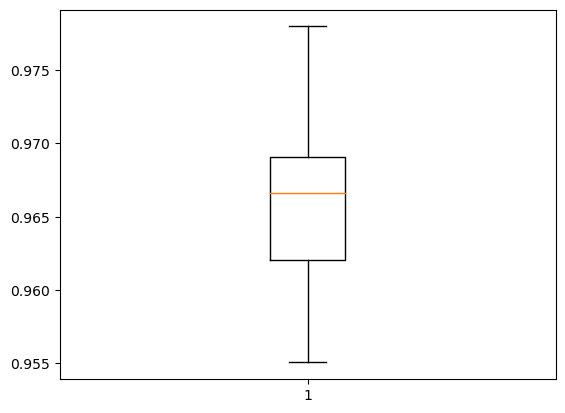

In [42]:
# borduce a boxplot of the 100 eigenvalues
plt.boxplot(eigs)
plt.show()

____________________________________________